In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
# lonMin = (float)(config['REGION']['LON_MIN'])
# lonMax = (float)(config['REGION']['LON_MAX'])

# latMin = (float)(config['REGION']['LAT_MIN'])
# latMax = (float)(config['REGION']['LAT_MAX'])

lonMin = (float)(-119.50)
lonMax = (float)(-119.00)

latMin = (float)(34.00)
latMax = (float)(34.16)

print(lonMin,latMin)
print(lonMax,latMax)

# increStep = (float)(config['HEATMAP']['INCR_STEP'])
# incrRes = (int)(config['HEATMAP']['INCR_RES'])
increStep = (float)(0.01)
incrRes = (int)(2)

-119.5 34.0
-119.0 34.16


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [7]:
fileDir = "../Data/M119_50_M119_00_34_00_34_16/HalfHourlyLE/"
dirToStore = "../Data/M119_50_M119_00_34_00_34_16/HalfHourlyTPSec/"
# fileDir = "../Data/M121_00_M119_00_33_50_34_50/HalfHourlyLE/"
# dirToStore = "../Data/M121_00_M119_00_33_50_34_50/HalfHourlyTPSec/"

In [8]:
#1 to load existing data
loadExisting = 0
neighTPCount = []
for i in range(totalStates):
    fileToRead = dirToStore + str(i) + '.npy'
    if(loadExisting == 1):
        neighTPCount.append(np.load(fileToRead))
    else:
        neighTPCount.append(np.zeros((totalStates * totalStates)))

In [9]:
def get_index_from_lon_lat(lon,lat):
    retVal = -1
    for boundary in boundaryArray: 
        if(lon >= boundary[0]) and (lon < boundary[1]) \
            and (lat >= boundary[2]) and (lat < boundary[3]):
            retVal = boundary[4]
            break 
    return retVal

In [10]:
def clear_tm_matrix():
    for i in range(horizontalAxis.shape[0] * verticalAxis.shape[0]):
        neighTPCount[i].fill(0)
        
def compute_transition_prob(firstNum):
    fileName1 = fileDir + str(firstNum) + '.csv'
    fileName2 = fileDir + str(firstNum+1) + '.csv'
    fileName3 = fileDir + str(firstNum+2) + '.csv'

    #transition probability for previous hour
    firstDF,_ = aISDM.load_data_from_csv(fileName1)
    #transition probability for current hour
    secondDF,_ = aISDM.load_data_from_csv(fileName2)
    #transition probability for next hour
    thirdDF,_ = aISDM.load_data_from_csv(fileName3)
    
    #vessels in previous hour
    prevVessels = aISDM.get_list_of_unique_mmsi(firstDF)
    #vessels in current hour
    currVessels = aISDM.get_list_of_unique_mmsi(secondDF)
    #vessels in next hour
    nextVessels = aISDM.get_list_of_unique_mmsi(thirdDF)
    
    #index based on MMSI
    #useful for indexing
    firstDF = firstDF.set_index('MMSI')
    secondDF = secondDF.set_index('MMSI')
    thirdDF = thirdDF.set_index('MMSI')
    
    #compute vessels of interest
    #this are vessels which are of interest
    vesselsOfInterest = list(set(prevVessels) & set(currVessels) & set(nextVessels))
    #iterate through every vessel
    #get the first LON and LAT coordinate for the first vessel
    for vessel in vesselsOfInterest:
        #get the LON and LAT value of the vessel
        #get the location where vessel was previously and is currently
        #now we have the location
        vesselPrevIndex = get_index_from_lon_lat(firstDF.loc[vessel,'LON'],firstDF.loc[vessel,'LAT'])
        vesselCurrIndex = get_index_from_lon_lat(secondDF.loc[vessel,'LON'],secondDF.loc[vessel,'LAT'])
        #now lets findout where this vessel is
        vesselNextIndex = get_index_from_lon_lat(thirdDF.loc[vessel,'LON'],thirdDF.loc[vessel,'LAT'])
        vesselPrevCurrIndex = (vesselPrevIndex * totalStates) + vesselCurrIndex
        neighTPCount[vesselNextIndex][vesselPrevCurrIndex] = neighTPCount[vesselNextIndex][vesselPrevCurrIndex] + 1

In [11]:
if(loadExisting == 0):
    clear_tm_matrix()
    for fileCounter in range(17517):
        try:
            compute_transition_prob(fileCounter)
            print("Done Computing %d"%(fileCounter))
        except KeyboardInterrupt:
            break

Done Computing 0
Done Computing 1
Done Computing 2
Done Computing 3
Done Computing 4
Done Computing 5
Done Computing 6
Done Computing 7
Done Computing 8
Done Computing 9
Done Computing 10
Done Computing 11
Done Computing 12
Done Computing 13
Done Computing 14
Done Computing 15
Done Computing 16
Done Computing 17
Done Computing 18
Done Computing 19
Done Computing 20
Done Computing 21
Done Computing 22
Done Computing 23
Done Computing 24
Done Computing 25
Done Computing 26
Done Computing 27
Done Computing 28
Done Computing 29
Done Computing 30
Done Computing 31
Done Computing 32
Done Computing 33
Done Computing 34
Done Computing 35
Done Computing 36
Done Computing 37
Done Computing 38
Done Computing 39
Done Computing 40
Done Computing 41
Done Computing 42
Done Computing 43
Done Computing 44
Done Computing 45
Done Computing 46
Done Computing 47
Done Computing 48
Done Computing 49
Done Computing 50
Done Computing 51
Done Computing 52
Done Computing 53
Done Computing 54
Done Computing 55
Do

Done Computing 439
Done Computing 440
Done Computing 441
Done Computing 442
Done Computing 443
Done Computing 444
Done Computing 445
Done Computing 446
Done Computing 447
Done Computing 448
Done Computing 449
Done Computing 450
Done Computing 451
Done Computing 452
Done Computing 453
Done Computing 454
Done Computing 455
Done Computing 456
Done Computing 457
Done Computing 458
Done Computing 459
Done Computing 460
Done Computing 461
Done Computing 462
Done Computing 463
Done Computing 464
Done Computing 465
Done Computing 466
Done Computing 467
Done Computing 468
Done Computing 469
Done Computing 470
Done Computing 471
Done Computing 472
Done Computing 473
Done Computing 474
Done Computing 475
Done Computing 476
Done Computing 477
Done Computing 478
Done Computing 479
Done Computing 480
Done Computing 481
Done Computing 482
Done Computing 483
Done Computing 484
Done Computing 485
Done Computing 486
Done Computing 487
Done Computing 488
Done Computing 489
Done Computing 490
Done Computi

Done Computing 884
Done Computing 885
Done Computing 886
Done Computing 887
Done Computing 888
Done Computing 889
Done Computing 890
Done Computing 891
Done Computing 892
Done Computing 893
Done Computing 894
Done Computing 895
Done Computing 896
Done Computing 897
Done Computing 898
Done Computing 899
Done Computing 900
Done Computing 901
Done Computing 902
Done Computing 903
Done Computing 904
Done Computing 905
Done Computing 906
Done Computing 907
Done Computing 908
Done Computing 909
Done Computing 910
Done Computing 911
Done Computing 912
Done Computing 913
Done Computing 914
Done Computing 915
Done Computing 916
Done Computing 917
Done Computing 918
Done Computing 919
Done Computing 920
Done Computing 921
Done Computing 922
Done Computing 923
Done Computing 924
Done Computing 925
Done Computing 926
Done Computing 927
Done Computing 928
Done Computing 929
Done Computing 930
Done Computing 931
Done Computing 932
Done Computing 933
Done Computing 934
Done Computing 935
Done Computi

Done Computing 1329
Done Computing 1330
Done Computing 1331
Done Computing 1332
Done Computing 1333
Done Computing 1334
Done Computing 1335
Done Computing 1336
Done Computing 1337
Done Computing 1338
Done Computing 1339
Done Computing 1340
Done Computing 1341
Done Computing 1342
Done Computing 1343
Done Computing 1344
Done Computing 1345
Done Computing 1346
Done Computing 1347
Done Computing 1348
Done Computing 1349
Done Computing 1350
Done Computing 1351
Done Computing 1352
Done Computing 1353
Done Computing 1354
Done Computing 1355
Done Computing 1356
Done Computing 1357
Done Computing 1358
Done Computing 1359
Done Computing 1360
Done Computing 1361
Done Computing 1362
Done Computing 1363
Done Computing 1364
Done Computing 1365
Done Computing 1366
Done Computing 1367
Done Computing 1368
Done Computing 1369
Done Computing 1370
Done Computing 1371
Done Computing 1372
Done Computing 1373
Done Computing 1374
Done Computing 1375
Done Computing 1376
Done Computing 1377
Done Computing 1378


Done Computing 1768
Done Computing 1769
Done Computing 1770
Done Computing 1771
Done Computing 1772
Done Computing 1773
Done Computing 1774
Done Computing 1775
Done Computing 1776
Done Computing 1777
Done Computing 1778
Done Computing 1779
Done Computing 1780
Done Computing 1781
Done Computing 1782
Done Computing 1783
Done Computing 1784
Done Computing 1785
Done Computing 1786
Done Computing 1787
Done Computing 1788
Done Computing 1789
Done Computing 1790
Done Computing 1791
Done Computing 1792
Done Computing 1793
Done Computing 1794
Done Computing 1795
Done Computing 1796
Done Computing 1797
Done Computing 1798
Done Computing 1799
Done Computing 1800
Done Computing 1801
Done Computing 1802
Done Computing 1803
Done Computing 1804
Done Computing 1805
Done Computing 1806
Done Computing 1807
Done Computing 1808
Done Computing 1809
Done Computing 1810
Done Computing 1811
Done Computing 1812
Done Computing 1813
Done Computing 1814
Done Computing 1815
Done Computing 1816
Done Computing 1817


Done Computing 2200
Done Computing 2201
Done Computing 2202
Done Computing 2203
Done Computing 2204
Done Computing 2205
Done Computing 2206
Done Computing 2207
Done Computing 2208
Done Computing 2209
Done Computing 2210
Done Computing 2211
Done Computing 2212
Done Computing 2213
Done Computing 2214
Done Computing 2215
Done Computing 2216
Done Computing 2217
Done Computing 2218
Done Computing 2219
Done Computing 2220
Done Computing 2221
Done Computing 2222
Done Computing 2223
Done Computing 2224
Done Computing 2225
Done Computing 2226
Done Computing 2227
Done Computing 2228
Done Computing 2229
Done Computing 2230
Done Computing 2231
Done Computing 2232
Done Computing 2233
Done Computing 2234
Done Computing 2235
Done Computing 2236
Done Computing 2237
Done Computing 2238
Done Computing 2239
Done Computing 2240
Done Computing 2241
Done Computing 2242
Done Computing 2243
Done Computing 2244
Done Computing 2245
Done Computing 2246
Done Computing 2247
Done Computing 2248
Done Computing 2249


Done Computing 2629
Done Computing 2630
Done Computing 2631
Done Computing 2632
Done Computing 2633
Done Computing 2634
Done Computing 2635
Done Computing 2636
Done Computing 2637
Done Computing 2638
Done Computing 2639
Done Computing 2640
Done Computing 2641
Done Computing 2642
Done Computing 2643
Done Computing 2644
Done Computing 2645
Done Computing 2646
Done Computing 2647
Done Computing 2648
Done Computing 2649
Done Computing 2650
Done Computing 2651
Done Computing 2652
Done Computing 2653
Done Computing 2654
Done Computing 2655
Done Computing 2656
Done Computing 2657
Done Computing 2658
Done Computing 2659
Done Computing 2660
Done Computing 2661
Done Computing 2662
Done Computing 2663
Done Computing 2664
Done Computing 2665
Done Computing 2666
Done Computing 2667
Done Computing 2668
Done Computing 2669
Done Computing 2670
Done Computing 2671
Done Computing 2672
Done Computing 2673
Done Computing 2674
Done Computing 2675
Done Computing 2676
Done Computing 2677
Done Computing 2678


Done Computing 3050
Done Computing 3051
Done Computing 3052
Done Computing 3053
Done Computing 3054
Done Computing 3055
Done Computing 3056
Done Computing 3057
Done Computing 3058
Done Computing 3059
Done Computing 3060
Done Computing 3061
Done Computing 3062
Done Computing 3063
Done Computing 3064
Done Computing 3065
Done Computing 3066
Done Computing 3067
Done Computing 3068
Done Computing 3069
Done Computing 3070
Done Computing 3071
Done Computing 3072
Done Computing 3073
Done Computing 3074
Done Computing 3075
Done Computing 3076
Done Computing 3077
Done Computing 3078
Done Computing 3079
Done Computing 3080
Done Computing 3081
Done Computing 3082
Done Computing 3083
Done Computing 3084
Done Computing 3085
Done Computing 3086
Done Computing 3087
Done Computing 3088
Done Computing 3089
Done Computing 3090
Done Computing 3091
Done Computing 3092
Done Computing 3093
Done Computing 3094
Done Computing 3095
Done Computing 3096
Done Computing 3097
Done Computing 3098
Done Computing 3099


Done Computing 3463
Done Computing 3464
Done Computing 3465
Done Computing 3466
Done Computing 3467
Done Computing 3468
Done Computing 3469
Done Computing 3470
Done Computing 3471
Done Computing 3472
Done Computing 3473
Done Computing 3474
Done Computing 3475
Done Computing 3476
Done Computing 3477
Done Computing 3478
Done Computing 3479
Done Computing 3480
Done Computing 3481
Done Computing 3482
Done Computing 3483
Done Computing 3484
Done Computing 3485
Done Computing 3486
Done Computing 3487
Done Computing 3488
Done Computing 3489
Done Computing 3490
Done Computing 3491
Done Computing 3492
Done Computing 3493
Done Computing 3494
Done Computing 3495
Done Computing 3496
Done Computing 3497
Done Computing 3498
Done Computing 3499
Done Computing 3500
Done Computing 3501
Done Computing 3502
Done Computing 3503
Done Computing 3504
Done Computing 3505
Done Computing 3506
Done Computing 3507
Done Computing 3508
Done Computing 3509
Done Computing 3510
Done Computing 3511
Done Computing 3512


Done Computing 3898
Done Computing 3899
Done Computing 3900
Done Computing 3901
Done Computing 3902
Done Computing 3903
Done Computing 3904
Done Computing 3905
Done Computing 3906
Done Computing 3907
Done Computing 3908
Done Computing 3909
Done Computing 3910
Done Computing 3911
Done Computing 3912
Done Computing 3913
Done Computing 3914
Done Computing 3915
Done Computing 3916
Done Computing 3917
Done Computing 3918
Done Computing 3919
Done Computing 3920
Done Computing 3921
Done Computing 3922
Done Computing 3923
Done Computing 3924
Done Computing 3925
Done Computing 3926
Done Computing 3927
Done Computing 3928
Done Computing 3929
Done Computing 3930
Done Computing 3931
Done Computing 3932
Done Computing 3933
Done Computing 3934
Done Computing 3935
Done Computing 3936
Done Computing 3937
Done Computing 3938
Done Computing 3939
Done Computing 3940
Done Computing 3941
Done Computing 3942
Done Computing 3943
Done Computing 3944
Done Computing 3945
Done Computing 3946
Done Computing 3947


Done Computing 4313
Done Computing 4314
Done Computing 4315
Done Computing 4316
Done Computing 4317
Done Computing 4318
Done Computing 4319
Done Computing 4320
Done Computing 4321
Done Computing 4322
Done Computing 4323
Done Computing 4324
Done Computing 4325
Done Computing 4326
Done Computing 4327
Done Computing 4328
Done Computing 4329
Done Computing 4330
Done Computing 4331
Done Computing 4332
Done Computing 4333
Done Computing 4334
Done Computing 4335
Done Computing 4336
Done Computing 4337
Done Computing 4338
Done Computing 4339
Done Computing 4340
Done Computing 4341
Done Computing 4342
Done Computing 4343
Done Computing 4344
Done Computing 4345
Done Computing 4346
Done Computing 4347
Done Computing 4348
Done Computing 4349
Done Computing 4350
Done Computing 4351
Done Computing 4352
Done Computing 4353
Done Computing 4354
Done Computing 4355
Done Computing 4356
Done Computing 4357
Done Computing 4358
Done Computing 4359
Done Computing 4360
Done Computing 4361
Done Computing 4362


Done Computing 4723
Done Computing 4724
Done Computing 4725
Done Computing 4726
Done Computing 4727
Done Computing 4728
Done Computing 4729
Done Computing 4730
Done Computing 4731
Done Computing 4732
Done Computing 4733
Done Computing 4734
Done Computing 4735
Done Computing 4736
Done Computing 4737
Done Computing 4738
Done Computing 4739
Done Computing 4740
Done Computing 4741
Done Computing 4742
Done Computing 4743
Done Computing 4744
Done Computing 4745
Done Computing 4746
Done Computing 4747
Done Computing 4748
Done Computing 4749
Done Computing 4750
Done Computing 4751
Done Computing 4752
Done Computing 4753
Done Computing 4754
Done Computing 4755
Done Computing 4756
Done Computing 4757
Done Computing 4758
Done Computing 4759
Done Computing 4760
Done Computing 4761
Done Computing 4762
Done Computing 4763
Done Computing 4764
Done Computing 4765
Done Computing 4766
Done Computing 4767
Done Computing 4768
Done Computing 4769
Done Computing 4770
Done Computing 4771
Done Computing 4772


Done Computing 5171
Done Computing 5172
Done Computing 5173
Done Computing 5174
Done Computing 5175
Done Computing 5176
Done Computing 5177
Done Computing 5178
Done Computing 5179
Done Computing 5180
Done Computing 5181
Done Computing 5182
Done Computing 5183
Done Computing 5184
Done Computing 5185
Done Computing 5186
Done Computing 5187
Done Computing 5188
Done Computing 5189
Done Computing 5190
Done Computing 5191
Done Computing 5192
Done Computing 5193
Done Computing 5194
Done Computing 5195
Done Computing 5196
Done Computing 5197
Done Computing 5198
Done Computing 5199
Done Computing 5200
Done Computing 5201
Done Computing 5202
Done Computing 5203
Done Computing 5204
Done Computing 5205
Done Computing 5206
Done Computing 5207
Done Computing 5208
Done Computing 5209
Done Computing 5210
Done Computing 5211
Done Computing 5212
Done Computing 5213
Done Computing 5214
Done Computing 5215
Done Computing 5216
Done Computing 5217
Done Computing 5218
Done Computing 5219
Done Computing 5220


Done Computing 5614
Done Computing 5615
Done Computing 5616
Done Computing 5617
Done Computing 5618
Done Computing 5619
Done Computing 5620
Done Computing 5621
Done Computing 5622
Done Computing 5623
Done Computing 5624
Done Computing 5625
Done Computing 5626
Done Computing 5627
Done Computing 5628
Done Computing 5629
Done Computing 5630
Done Computing 5631
Done Computing 5632
Done Computing 5633
Done Computing 5634
Done Computing 5635
Done Computing 5636
Done Computing 5637
Done Computing 5638
Done Computing 5639
Done Computing 5640
Done Computing 5641
Done Computing 5642
Done Computing 5643
Done Computing 5644
Done Computing 5645
Done Computing 5646
Done Computing 5647
Done Computing 5648
Done Computing 5649
Done Computing 5650
Done Computing 5651
Done Computing 5652
Done Computing 5653
Done Computing 5654
Done Computing 5655
Done Computing 5656
Done Computing 5657
Done Computing 5658
Done Computing 5659
Done Computing 5660
Done Computing 5661
Done Computing 5662
Done Computing 5663


Done Computing 6024
Done Computing 6025
Done Computing 6026
Done Computing 6027
Done Computing 6028
Done Computing 6029
Done Computing 6030
Done Computing 6031
Done Computing 6032
Done Computing 6033
Done Computing 6034
Done Computing 6035
Done Computing 6036
Done Computing 6037
Done Computing 6038
Done Computing 6039
Done Computing 6040
Done Computing 6041
Done Computing 6042
Done Computing 6043
Done Computing 6044
Done Computing 6045
Done Computing 6046
Done Computing 6047
Done Computing 6048
Done Computing 6049
Done Computing 6050
Done Computing 6051
Done Computing 6052
Done Computing 6053
Done Computing 6054
Done Computing 6055
Done Computing 6056
Done Computing 6057
Done Computing 6058
Done Computing 6059
Done Computing 6060
Done Computing 6061
Done Computing 6062
Done Computing 6063
Done Computing 6064
Done Computing 6065
Done Computing 6066
Done Computing 6067
Done Computing 6068
Done Computing 6069
Done Computing 6070
Done Computing 6071
Done Computing 6072
Done Computing 6073


Done Computing 6435
Done Computing 6436
Done Computing 6437
Done Computing 6438
Done Computing 6439
Done Computing 6440
Done Computing 6441
Done Computing 6442
Done Computing 6443
Done Computing 6444
Done Computing 6445
Done Computing 6446
Done Computing 6447
Done Computing 6448
Done Computing 6449
Done Computing 6450
Done Computing 6451
Done Computing 6452
Done Computing 6453
Done Computing 6454
Done Computing 6455
Done Computing 6456
Done Computing 6457
Done Computing 6458
Done Computing 6459
Done Computing 6460
Done Computing 6461
Done Computing 6462
Done Computing 6463
Done Computing 6464
Done Computing 6465
Done Computing 6466
Done Computing 6467
Done Computing 6468
Done Computing 6469
Done Computing 6470
Done Computing 6471
Done Computing 6472
Done Computing 6473
Done Computing 6474
Done Computing 6475
Done Computing 6476
Done Computing 6477
Done Computing 6478
Done Computing 6479
Done Computing 6480
Done Computing 6481
Done Computing 6482
Done Computing 6483
Done Computing 6484


Done Computing 6878
Done Computing 6879
Done Computing 6880
Done Computing 6881
Done Computing 6882
Done Computing 6883
Done Computing 6884
Done Computing 6885
Done Computing 6886
Done Computing 6887
Done Computing 6888
Done Computing 6889
Done Computing 6890
Done Computing 6891
Done Computing 6892
Done Computing 6893
Done Computing 6894
Done Computing 6895
Done Computing 6896
Done Computing 6897
Done Computing 6898
Done Computing 6899
Done Computing 6900
Done Computing 6901
Done Computing 6902
Done Computing 6903
Done Computing 6904
Done Computing 6905
Done Computing 6906
Done Computing 6907
Done Computing 6908
Done Computing 6909
Done Computing 6910
Done Computing 6911
Done Computing 6912
Done Computing 6913
Done Computing 6914
Done Computing 6915
Done Computing 6916
Done Computing 6917
Done Computing 6918
Done Computing 6919
Done Computing 6920
Done Computing 6921
Done Computing 6922
Done Computing 6923
Done Computing 6924
Done Computing 6925
Done Computing 6926
Done Computing 6927


Done Computing 7291
Done Computing 7292
Done Computing 7293
Done Computing 7294
Done Computing 7295
Done Computing 7296
Done Computing 7297
Done Computing 7298
Done Computing 7299
Done Computing 7300
Done Computing 7301
Done Computing 7302
Done Computing 7303
Done Computing 7304
Done Computing 7305
Done Computing 7306
Done Computing 7307
Done Computing 7308
Done Computing 7309
Done Computing 7310
Done Computing 7311
Done Computing 7312
Done Computing 7313
Done Computing 7314
Done Computing 7315
Done Computing 7316
Done Computing 7317
Done Computing 7318
Done Computing 7319
Done Computing 7320
Done Computing 7321
Done Computing 7322
Done Computing 7323
Done Computing 7324
Done Computing 7325
Done Computing 7326
Done Computing 7327
Done Computing 7328
Done Computing 7329
Done Computing 7330
Done Computing 7331
Done Computing 7332
Done Computing 7333
Done Computing 7334
Done Computing 7335
Done Computing 7336
Done Computing 7337
Done Computing 7338
Done Computing 7339
Done Computing 7340


Done Computing 7734
Done Computing 7735
Done Computing 7736
Done Computing 7737
Done Computing 7738
Done Computing 7739
Done Computing 7740
Done Computing 7741
Done Computing 7742
Done Computing 7743
Done Computing 7744
Done Computing 7745
Done Computing 7746
Done Computing 7747
Done Computing 7748
Done Computing 7749
Done Computing 7750
Done Computing 7751
Done Computing 7752
Done Computing 7753
Done Computing 7754
Done Computing 7755
Done Computing 7756
Done Computing 7757
Done Computing 7758
Done Computing 7759
Done Computing 7760
Done Computing 7761
Done Computing 7762
Done Computing 7763
Done Computing 7764
Done Computing 7765
Done Computing 7766
Done Computing 7767
Done Computing 7768
Done Computing 7769
Done Computing 7770
Done Computing 7771
Done Computing 7772
Done Computing 7773
Done Computing 7774
Done Computing 7775
Done Computing 7776
Done Computing 7777
Done Computing 7778
Done Computing 7779
Done Computing 7780
Done Computing 7781
Done Computing 7782
Done Computing 7783


Done Computing 8178
Done Computing 8179
Done Computing 8180
Done Computing 8181
Done Computing 8182
Done Computing 8183
Done Computing 8184
Done Computing 8185
Done Computing 8186
Done Computing 8187
Done Computing 8188
Done Computing 8189
Done Computing 8190
Done Computing 8191
Done Computing 8192
Done Computing 8193
Done Computing 8194
Done Computing 8195
Done Computing 8196
Done Computing 8197
Done Computing 8198
Done Computing 8199
Done Computing 8200
Done Computing 8201
Done Computing 8202
Done Computing 8203
Done Computing 8204
Done Computing 8205
Done Computing 8206
Done Computing 8207
Done Computing 8208
Done Computing 8209
Done Computing 8210
Done Computing 8211
Done Computing 8212
Done Computing 8213
Done Computing 8214
Done Computing 8215
Done Computing 8216
Done Computing 8217
Done Computing 8218
Done Computing 8219
Done Computing 8220
Done Computing 8221
Done Computing 8222
Done Computing 8223
Done Computing 8224
Done Computing 8225
Done Computing 8226
Done Computing 8227


Done Computing 8618
Done Computing 8619
Done Computing 8620
Done Computing 8621
Done Computing 8622
Done Computing 8623
Done Computing 8624
Done Computing 8625
Done Computing 8626
Done Computing 8627
Done Computing 8628
Done Computing 8629
Done Computing 8630
Done Computing 8631
Done Computing 8632
Done Computing 8633
Done Computing 8634
Done Computing 8635
Done Computing 8636
Done Computing 8637
Done Computing 8638
Done Computing 8639
Done Computing 8640
Done Computing 8641
Done Computing 8642
Done Computing 8643
Done Computing 8644
Done Computing 8645
Done Computing 8646
Done Computing 8647
Done Computing 8648
Done Computing 8649
Done Computing 8650
Done Computing 8651
Done Computing 8652
Done Computing 8653
Done Computing 8654
Done Computing 8655
Done Computing 8656
Done Computing 8657
Done Computing 8658
Done Computing 8659
Done Computing 8660
Done Computing 8661
Done Computing 8662
Done Computing 8663
Done Computing 8664
Done Computing 8665
Done Computing 8666
Done Computing 8667


Done Computing 9059
Done Computing 9060
Done Computing 9061
Done Computing 9062
Done Computing 9063
Done Computing 9064
Done Computing 9065
Done Computing 9066
Done Computing 9067
Done Computing 9068
Done Computing 9069
Done Computing 9070
Done Computing 9071
Done Computing 9072
Done Computing 9073
Done Computing 9074
Done Computing 9075
Done Computing 9076
Done Computing 9077
Done Computing 9078
Done Computing 9079
Done Computing 9080
Done Computing 9081
Done Computing 9082
Done Computing 9083
Done Computing 9084
Done Computing 9085
Done Computing 9086
Done Computing 9087
Done Computing 9088
Done Computing 9089
Done Computing 9090
Done Computing 9091
Done Computing 9092
Done Computing 9093
Done Computing 9094
Done Computing 9095
Done Computing 9096
Done Computing 9097
Done Computing 9098
Done Computing 9099
Done Computing 9100
Done Computing 9101
Done Computing 9102
Done Computing 9103
Done Computing 9104
Done Computing 9105
Done Computing 9106
Done Computing 9107
Done Computing 9108


Done Computing 9501
Done Computing 9502
Done Computing 9503
Done Computing 9504
Done Computing 9505
Done Computing 9506
Done Computing 9507
Done Computing 9508
Done Computing 9509
Done Computing 9510
Done Computing 9511
Done Computing 9512
Done Computing 9513
Done Computing 9514
Done Computing 9515
Done Computing 9516
Done Computing 9517
Done Computing 9518
Done Computing 9519
Done Computing 9520
Done Computing 9521
Done Computing 9522
Done Computing 9523
Done Computing 9524
Done Computing 9525
Done Computing 9526
Done Computing 9527
Done Computing 9528
Done Computing 9529
Done Computing 9530
Done Computing 9531
Done Computing 9532
Done Computing 9533
Done Computing 9534
Done Computing 9535
Done Computing 9536
Done Computing 9537
Done Computing 9538
Done Computing 9539
Done Computing 9540
Done Computing 9541
Done Computing 9542
Done Computing 9543
Done Computing 9544
Done Computing 9545
Done Computing 9546
Done Computing 9547
Done Computing 9548
Done Computing 9549
Done Computing 9550


Done Computing 9924
Done Computing 9925
Done Computing 9926
Done Computing 9927
Done Computing 9928
Done Computing 9929
Done Computing 9930
Done Computing 9931
Done Computing 9932
Done Computing 9933
Done Computing 9934
Done Computing 9935
Done Computing 9936
Done Computing 9937
Done Computing 9938
Done Computing 9939
Done Computing 9940
Done Computing 9941
Done Computing 9942
Done Computing 9943
Done Computing 9944
Done Computing 9945
Done Computing 9946
Done Computing 9947
Done Computing 9948
Done Computing 9949
Done Computing 9950
Done Computing 9951
Done Computing 9952
Done Computing 9953
Done Computing 9954
Done Computing 9955
Done Computing 9956
Done Computing 9957
Done Computing 9958
Done Computing 9959
Done Computing 9960
Done Computing 9961
Done Computing 9962
Done Computing 9963
Done Computing 9964
Done Computing 9965
Done Computing 9966
Done Computing 9967
Done Computing 9968
Done Computing 9969
Done Computing 9970
Done Computing 9971
Done Computing 9972
Done Computing 9973


Done Computing 10318
Done Computing 10319
Done Computing 10320
Done Computing 10321
Done Computing 10322
Done Computing 10323
Done Computing 10324
Done Computing 10325
Done Computing 10326
Done Computing 10327
Done Computing 10328
Done Computing 10329
Done Computing 10330
Done Computing 10331
Done Computing 10332
Done Computing 10333
Done Computing 10334
Done Computing 10335
Done Computing 10336
Done Computing 10337
Done Computing 10338
Done Computing 10339
Done Computing 10340
Done Computing 10341
Done Computing 10342
Done Computing 10343
Done Computing 10344
Done Computing 10345
Done Computing 10346
Done Computing 10347
Done Computing 10348
Done Computing 10349
Done Computing 10350
Done Computing 10351
Done Computing 10352
Done Computing 10353
Done Computing 10354
Done Computing 10355
Done Computing 10356
Done Computing 10357
Done Computing 10358
Done Computing 10359
Done Computing 10360
Done Computing 10361
Done Computing 10362
Done Computing 10363
Done Computing 10364
Done Computin

Done Computing 10711
Done Computing 10712
Done Computing 10713
Done Computing 10714
Done Computing 10715
Done Computing 10716
Done Computing 10717
Done Computing 10718
Done Computing 10719
Done Computing 10720
Done Computing 10721
Done Computing 10722
Done Computing 10723
Done Computing 10724
Done Computing 10725
Done Computing 10726
Done Computing 10727
Done Computing 10728
Done Computing 10729
Done Computing 10730
Done Computing 10731
Done Computing 10732
Done Computing 10733
Done Computing 10734
Done Computing 10735
Done Computing 10736
Done Computing 10737
Done Computing 10738
Done Computing 10739
Done Computing 10740
Done Computing 10741
Done Computing 10742
Done Computing 10743
Done Computing 10744
Done Computing 10745
Done Computing 10746
Done Computing 10747
Done Computing 10748
Done Computing 10749
Done Computing 10750
Done Computing 10751
Done Computing 10752
Done Computing 10753
Done Computing 10754
Done Computing 10755
Done Computing 10756
Done Computing 10757
Done Computin

Done Computing 11105
Done Computing 11106
Done Computing 11107
Done Computing 11108
Done Computing 11109
Done Computing 11110
Done Computing 11111
Done Computing 11112
Done Computing 11113
Done Computing 11114
Done Computing 11115
Done Computing 11116
Done Computing 11117
Done Computing 11118
Done Computing 11119
Done Computing 11120
Done Computing 11121
Done Computing 11122
Done Computing 11123
Done Computing 11124
Done Computing 11125
Done Computing 11126
Done Computing 11127
Done Computing 11128
Done Computing 11129
Done Computing 11130
Done Computing 11131
Done Computing 11132
Done Computing 11133
Done Computing 11134
Done Computing 11135
Done Computing 11136
Done Computing 11137
Done Computing 11138
Done Computing 11139
Done Computing 11140
Done Computing 11141
Done Computing 11142
Done Computing 11143
Done Computing 11144
Done Computing 11145
Done Computing 11146
Done Computing 11147
Done Computing 11148
Done Computing 11149
Done Computing 11150
Done Computing 11151
Done Computin

Done Computing 11503
Done Computing 11504
Done Computing 11505
Done Computing 11506
Done Computing 11507
Done Computing 11508
Done Computing 11509
Done Computing 11510
Done Computing 11511
Done Computing 11512
Done Computing 11513
Done Computing 11514
Done Computing 11515
Done Computing 11516
Done Computing 11517
Done Computing 11518
Done Computing 11519
Done Computing 11520
Done Computing 11521
Done Computing 11522
Done Computing 11523
Done Computing 11524
Done Computing 11525
Done Computing 11526
Done Computing 11527
Done Computing 11528
Done Computing 11529
Done Computing 11530
Done Computing 11531
Done Computing 11532
Done Computing 11533
Done Computing 11534
Done Computing 11535
Done Computing 11536
Done Computing 11537
Done Computing 11538
Done Computing 11539
Done Computing 11540
Done Computing 11541
Done Computing 11542
Done Computing 11543
Done Computing 11544
Done Computing 11545
Done Computing 11546
Done Computing 11547
Done Computing 11548
Done Computing 11549
Done Computin

Done Computing 11895
Done Computing 11896
Done Computing 11897
Done Computing 11898
Done Computing 11899
Done Computing 11900
Done Computing 11901
Done Computing 11902
Done Computing 11903
Done Computing 11904
Done Computing 11905
Done Computing 11906
Done Computing 11907
Done Computing 11908
Done Computing 11909
Done Computing 11910
Done Computing 11911
Done Computing 11912
Done Computing 11913
Done Computing 11914
Done Computing 11915
Done Computing 11916
Done Computing 11917
Done Computing 11918
Done Computing 11919
Done Computing 11920
Done Computing 11921
Done Computing 11922
Done Computing 11923
Done Computing 11924
Done Computing 11925
Done Computing 11926
Done Computing 11927
Done Computing 11928
Done Computing 11929
Done Computing 11930
Done Computing 11931
Done Computing 11932
Done Computing 11933
Done Computing 11934
Done Computing 11935
Done Computing 11936
Done Computing 11937
Done Computing 11938
Done Computing 11939
Done Computing 11940
Done Computing 11941
Done Computin

Done Computing 12293
Done Computing 12294
Done Computing 12295
Done Computing 12296
Done Computing 12297
Done Computing 12298
Done Computing 12299
Done Computing 12300
Done Computing 12301
Done Computing 12302
Done Computing 12303
Done Computing 12304
Done Computing 12305
Done Computing 12306
Done Computing 12307
Done Computing 12308
Done Computing 12309
Done Computing 12310
Done Computing 12311
Done Computing 12312
Done Computing 12313
Done Computing 12314
Done Computing 12315
Done Computing 12316
Done Computing 12317
Done Computing 12318
Done Computing 12319
Done Computing 12320
Done Computing 12321
Done Computing 12322
Done Computing 12323
Done Computing 12324
Done Computing 12325
Done Computing 12326
Done Computing 12327
Done Computing 12328
Done Computing 12329
Done Computing 12330
Done Computing 12331
Done Computing 12332
Done Computing 12333
Done Computing 12334
Done Computing 12335
Done Computing 12336
Done Computing 12337
Done Computing 12338
Done Computing 12339
Done Computin

Done Computing 12690
Done Computing 12691
Done Computing 12692
Done Computing 12693
Done Computing 12694
Done Computing 12695
Done Computing 12696
Done Computing 12697
Done Computing 12698
Done Computing 12699
Done Computing 12700
Done Computing 12701
Done Computing 12702
Done Computing 12703
Done Computing 12704
Done Computing 12705
Done Computing 12706
Done Computing 12707
Done Computing 12708
Done Computing 12709
Done Computing 12710
Done Computing 12711
Done Computing 12712
Done Computing 12713
Done Computing 12714
Done Computing 12715
Done Computing 12716
Done Computing 12717
Done Computing 12718
Done Computing 12719
Done Computing 12720
Done Computing 12721
Done Computing 12722
Done Computing 12723
Done Computing 12724
Done Computing 12725
Done Computing 12726
Done Computing 12727
Done Computing 12728
Done Computing 12729
Done Computing 12730
Done Computing 12731
Done Computing 12732
Done Computing 12733
Done Computing 12734
Done Computing 12735
Done Computing 12736
Done Computin

Done Computing 13088
Done Computing 13089
Done Computing 13090
Done Computing 13091
Done Computing 13092
Done Computing 13093
Done Computing 13094
Done Computing 13095
Done Computing 13096
Done Computing 13097
Done Computing 13098
Done Computing 13099
Done Computing 13100
Done Computing 13101
Done Computing 13102
Done Computing 13103
Done Computing 13104
Done Computing 13105
Done Computing 13106
Done Computing 13107
Done Computing 13108
Done Computing 13109
Done Computing 13110
Done Computing 13111
Done Computing 13112
Done Computing 13113
Done Computing 13114
Done Computing 13115
Done Computing 13116
Done Computing 13117
Done Computing 13118
Done Computing 13119
Done Computing 13120
Done Computing 13121
Done Computing 13122
Done Computing 13123
Done Computing 13124
Done Computing 13125
Done Computing 13126
Done Computing 13127
Done Computing 13128
Done Computing 13129
Done Computing 13130
Done Computing 13131
Done Computing 13132
Done Computing 13133
Done Computing 13134
Done Computin

Done Computing 13493
Done Computing 13494
Done Computing 13495
Done Computing 13496
Done Computing 13497
Done Computing 13498
Done Computing 13499
Done Computing 13500
Done Computing 13501
Done Computing 13502
Done Computing 13503
Done Computing 13504
Done Computing 13505
Done Computing 13506
Done Computing 13507
Done Computing 13508
Done Computing 13509
Done Computing 13510
Done Computing 13511
Done Computing 13512
Done Computing 13513
Done Computing 13514
Done Computing 13515
Done Computing 13516
Done Computing 13517
Done Computing 13518
Done Computing 13519
Done Computing 13520
Done Computing 13521
Done Computing 13522
Done Computing 13523
Done Computing 13524
Done Computing 13525
Done Computing 13526
Done Computing 13527
Done Computing 13528
Done Computing 13529
Done Computing 13530
Done Computing 13531
Done Computing 13532
Done Computing 13533
Done Computing 13534
Done Computing 13535
Done Computing 13536
Done Computing 13537
Done Computing 13538
Done Computing 13539
Done Computin

Done Computing 13891
Done Computing 13892
Done Computing 13893
Done Computing 13894
Done Computing 13895
Done Computing 13896
Done Computing 13897
Done Computing 13898
Done Computing 13899
Done Computing 13900
Done Computing 13901
Done Computing 13902
Done Computing 13903
Done Computing 13904
Done Computing 13905
Done Computing 13906
Done Computing 13907
Done Computing 13908
Done Computing 13909
Done Computing 13910
Done Computing 13911
Done Computing 13912
Done Computing 13913
Done Computing 13914
Done Computing 13915
Done Computing 13916
Done Computing 13917
Done Computing 13918
Done Computing 13919
Done Computing 13920
Done Computing 13921
Done Computing 13922
Done Computing 13923
Done Computing 13924
Done Computing 13925
Done Computing 13926
Done Computing 13927
Done Computing 13928
Done Computing 13929
Done Computing 13930
Done Computing 13931
Done Computing 13932
Done Computing 13933
Done Computing 13934
Done Computing 13935
Done Computing 13936
Done Computing 13937
Done Computin

Done Computing 14286
Done Computing 14287
Done Computing 14288
Done Computing 14289
Done Computing 14290
Done Computing 14291
Done Computing 14292
Done Computing 14293
Done Computing 14294
Done Computing 14295
Done Computing 14296
Done Computing 14297
Done Computing 14298
Done Computing 14299
Done Computing 14300
Done Computing 14301
Done Computing 14302
Done Computing 14303
Done Computing 14304
Done Computing 14305
Done Computing 14306
Done Computing 14307
Done Computing 14308
Done Computing 14309
Done Computing 14310
Done Computing 14311
Done Computing 14312
Done Computing 14313
Done Computing 14314
Done Computing 14315
Done Computing 14316
Done Computing 14317
Done Computing 14318
Done Computing 14319
Done Computing 14320
Done Computing 14321
Done Computing 14322
Done Computing 14323
Done Computing 14324
Done Computing 14325
Done Computing 14326
Done Computing 14327
Done Computing 14328
Done Computing 14329
Done Computing 14330
Done Computing 14331
Done Computing 14332
Done Computin

Done Computing 14689
Done Computing 14690
Done Computing 14691
Done Computing 14692
Done Computing 14693
Done Computing 14694
Done Computing 14695
Done Computing 14696
Done Computing 14697
Done Computing 14698
Done Computing 14699
Done Computing 14700
Done Computing 14701
Done Computing 14702
Done Computing 14703
Done Computing 14704
Done Computing 14705
Done Computing 14706
Done Computing 14707
Done Computing 14708
Done Computing 14709
Done Computing 14710
Done Computing 14711
Done Computing 14712
Done Computing 14713
Done Computing 14714
Done Computing 14715
Done Computing 14716
Done Computing 14717
Done Computing 14718
Done Computing 14719
Done Computing 14720
Done Computing 14721
Done Computing 14722
Done Computing 14723
Done Computing 14724
Done Computing 14725
Done Computing 14726
Done Computing 14727
Done Computing 14728
Done Computing 14729
Done Computing 14730
Done Computing 14731
Done Computing 14732
Done Computing 14733
Done Computing 14734
Done Computing 14735
Done Computin

Done Computing 15093
Done Computing 15094
Done Computing 15095
Done Computing 15096
Done Computing 15097
Done Computing 15098
Done Computing 15099
Done Computing 15100
Done Computing 15101
Done Computing 15102
Done Computing 15103
Done Computing 15104
Done Computing 15105
Done Computing 15106
Done Computing 15107
Done Computing 15108
Done Computing 15109
Done Computing 15110
Done Computing 15111
Done Computing 15112
Done Computing 15113
Done Computing 15114
Done Computing 15115
Done Computing 15116
Done Computing 15117
Done Computing 15118
Done Computing 15119
Done Computing 15120
Done Computing 15121
Done Computing 15122
Done Computing 15123
Done Computing 15124
Done Computing 15125
Done Computing 15126
Done Computing 15127
Done Computing 15128
Done Computing 15129
Done Computing 15130
Done Computing 15131
Done Computing 15132
Done Computing 15133
Done Computing 15134
Done Computing 15135
Done Computing 15136
Done Computing 15137
Done Computing 15138
Done Computing 15139
Done Computin

Done Computing 15490
Done Computing 15491
Done Computing 15492
Done Computing 15493
Done Computing 15494
Done Computing 15495
Done Computing 15496
Done Computing 15497
Done Computing 15498
Done Computing 15499
Done Computing 15500
Done Computing 15501
Done Computing 15502
Done Computing 15503
Done Computing 15504
Done Computing 15505
Done Computing 15506
Done Computing 15507
Done Computing 15508
Done Computing 15509
Done Computing 15510
Done Computing 15511
Done Computing 15512
Done Computing 15513
Done Computing 15514
Done Computing 15515
Done Computing 15516
Done Computing 15517
Done Computing 15518
Done Computing 15519
Done Computing 15520
Done Computing 15521
Done Computing 15522
Done Computing 15523
Done Computing 15524
Done Computing 15525
Done Computing 15526
Done Computing 15527
Done Computing 15528
Done Computing 15529
Done Computing 15530
Done Computing 15531
Done Computing 15532
Done Computing 15533
Done Computing 15534
Done Computing 15535
Done Computing 15536
Done Computin

Done Computing 15891
Done Computing 15892
Done Computing 15893
Done Computing 15894
Done Computing 15895
Done Computing 15896
Done Computing 15897
Done Computing 15898
Done Computing 15899
Done Computing 15900
Done Computing 15901
Done Computing 15902
Done Computing 15903
Done Computing 15904
Done Computing 15905
Done Computing 15906
Done Computing 15907
Done Computing 15908
Done Computing 15909
Done Computing 15910
Done Computing 15911
Done Computing 15912
Done Computing 15913
Done Computing 15914
Done Computing 15915
Done Computing 15916
Done Computing 15917
Done Computing 15918
Done Computing 15919
Done Computing 15920
Done Computing 15921
Done Computing 15922
Done Computing 15923
Done Computing 15924
Done Computing 15925
Done Computing 15926
Done Computing 15927
Done Computing 15928
Done Computing 15929
Done Computing 15930
Done Computing 15931
Done Computing 15932
Done Computing 15933
Done Computing 15934
Done Computing 15935
Done Computing 15936
Done Computing 15937
Done Computin

Done Computing 16299
Done Computing 16300
Done Computing 16301
Done Computing 16302
Done Computing 16303
Done Computing 16304
Done Computing 16305
Done Computing 16306
Done Computing 16307
Done Computing 16308
Done Computing 16309
Done Computing 16310
Done Computing 16311
Done Computing 16312
Done Computing 16313
Done Computing 16314
Done Computing 16315
Done Computing 16316
Done Computing 16317
Done Computing 16318
Done Computing 16319
Done Computing 16320
Done Computing 16321
Done Computing 16322
Done Computing 16323
Done Computing 16324
Done Computing 16325
Done Computing 16326
Done Computing 16327
Done Computing 16328
Done Computing 16329
Done Computing 16330
Done Computing 16331
Done Computing 16332
Done Computing 16333
Done Computing 16334
Done Computing 16335
Done Computing 16336
Done Computing 16337
Done Computing 16338
Done Computing 16339
Done Computing 16340
Done Computing 16341
Done Computing 16342
Done Computing 16343
Done Computing 16344
Done Computing 16345
Done Computin

Done Computing 16703
Done Computing 16704
Done Computing 16705
Done Computing 16706
Done Computing 16707
Done Computing 16708
Done Computing 16709
Done Computing 16710
Done Computing 16711
Done Computing 16712
Done Computing 16713
Done Computing 16714
Done Computing 16715
Done Computing 16716
Done Computing 16717
Done Computing 16718
Done Computing 16719
Done Computing 16720
Done Computing 16721
Done Computing 16722
Done Computing 16723
Done Computing 16724
Done Computing 16725
Done Computing 16726
Done Computing 16727
Done Computing 16728
Done Computing 16729
Done Computing 16730
Done Computing 16731
Done Computing 16732
Done Computing 16733
Done Computing 16734
Done Computing 16735
Done Computing 16736
Done Computing 16737
Done Computing 16738
Done Computing 16739
Done Computing 16740
Done Computing 16741
Done Computing 16742
Done Computing 16743
Done Computing 16744
Done Computing 16745
Done Computing 16746
Done Computing 16747
Done Computing 16748
Done Computing 16749
Done Computin

Done Computing 17111
Done Computing 17112
Done Computing 17113
Done Computing 17114
Done Computing 17115
Done Computing 17116
Done Computing 17117
Done Computing 17118
Done Computing 17119
Done Computing 17120
Done Computing 17121
Done Computing 17122
Done Computing 17123
Done Computing 17124
Done Computing 17125
Done Computing 17126
Done Computing 17127
Done Computing 17128
Done Computing 17129
Done Computing 17130
Done Computing 17131
Done Computing 17132
Done Computing 17133
Done Computing 17134
Done Computing 17135
Done Computing 17136
Done Computing 17137
Done Computing 17138
Done Computing 17139
Done Computing 17140
Done Computing 17141
Done Computing 17142
Done Computing 17143
Done Computing 17144
Done Computing 17145
Done Computing 17146
Done Computing 17147
Done Computing 17148
Done Computing 17149
Done Computing 17150
Done Computing 17151
Done Computing 17152
Done Computing 17153
Done Computing 17154
Done Computing 17155
Done Computing 17156
Done Computing 17157
Done Computin

Done Computing 17513
Done Computing 17514
Done Computing 17515
Done Computing 17516


In [12]:
if(loadExisting == 0):
    #destination directory
    for neighb in range(totalStates):
        opFile = dirToStore + str(neighb)+'.npy'
        np.save(opFile, neighTPCount[neighb])

In [13]:
#first lets make sum of probabilities
#this sum should be equal to tPCurrentSum
sumCount = np.zeros(totalStates*totalStates)
for i in range(totalStates):
    sumCount = sumCount + neighTPCount[i]

In [14]:
if(loadExisting == 0):
    #make transition probability matrix
    #A_{ij} i.e. trantition from i to j
    tpMatrix = np.zeros(((totalStates*totalStates),totalStates))
    
    #we will first fill columns
    #then rows
    #just like numpy
    #so i will be row count
    #j will be column count
    # for i in range(1):
    for i in range(tpMatrix.shape[0]):
        for j in range(tpMatrix.shape[1]):
            if(sumCount[i] > 0):
                tpMatrix[i,j] = neighTPCount[j][i]/sumCount[i]
    #             print("YAY")
                if(tpMatrix[i,j] > 0):
                    print(tpMatrix[i,j])

1.0
1.0
0.9090909090909091
0.030303030303030304
0.030303030303030304
0.030303030303030304
1.0
1.0
1.0
1.0
1.0
0.9166666666666666
0.08333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.2857142857142857
0.14285714285714285
0.5714285714285714
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.25
0.25
0.25
0.25
1.0
0.1111111111111111
0.1111111111111111
0.3333333333333333
0.3333333333333333
0.1111111111111111
0.45454545454545453
0.09090909090909091
0.09090909090909091
0.18181818181818182
0.09090909090909091
0.09090909090909091
0.16666666666666666
0.5
0.16666666666666666
0.16666666666666666
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.16666666666666666
0.16666666666666666
0.6666666666666666
0.25
0.25
0.5
0.2
0.4
0.2
0.2
0.6666666666666666
0.3333333333333333
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.5
0.25
0.25
0.5
0.5
0.6666666666666666
0.3333333333333333
1.0
1.0
0.5
0.5
0.75

1.0
0.5
0.5
1.0
1.0
0.5
0.5
0.375
0.125
0.5
0.13333333333333333
0.06666666666666667
0.13333333333333333
0.5333333333333333
0.13333333333333333
0.15384615384615385
0.07692307692307693
0.6923076923076923
0.07692307692307693
0.6666666666666666
0.3333333333333333
1.0
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.375
0.125
0.125
0.125
0.125
0.125
0.2
0.2
0.6
0.2857142857142857
0.14285714285714285
0.2857142857142857
0.14285714285714285
0.14285714285714285
0.25
0.75
1.0
1.0
1.0
0.6666666666666666
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
1.0
1.0
0.5
0.5
0.25
0.25
0.5
1.0
0.5
0.5
0.2
0.4
0.2
0.2
0.06666666666666667
0.06666666666666667
0.4666666666666667
0.3333333333333333
0.06666666666666667
0.23333333333333334
0.1
0.03333333333333333
0.03333333333333333
0.2
0.3
0.1
0.2727272727272727
0.36363636363636365
0.36363636363636365
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0


1.0
0.6666666666666666
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
0.25
0.75
0.5
0.5
0.3333333333333333
0.5
0.16666666666666666
0.5
0.5
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
1.0
1.0
0.5
0.5
0.14285714285714285
0.2857142857142857
0.5714285714285714
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
1.0
1.0
0.75
0.25
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.25
0.5
0.25
1.0
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
1.0
0.5
0.5
0.5
0.5
0.5
0.5
1.0
0.2
0.8
1.0
0.2
0.4
0.2
0.2
0.75
0.25
0.5
0.5
1.0
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
1.0
0.3333333333333333
0.6666666666666666
0.625
0.375
1.0
1.0
1.0
1.0
0.25
0.75
0.6
0.4
0.6
0.4
0.5
0.5
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.42857142857142855
0.42857142857142855
0.14285714285714285
0.18181818181818182
0.45454545454545453
0.36363636363636365
0.75
0.25
1.0
1.0
1.0
0.5
0.5
0

1.0
1.0
0.6
0.4
0.0625
0.25
0.375
0.125
0.1875
0.23076923076923078
0.38461538461538464
0.07692307692307693
0.07692307692307693
0.23076923076923078
0.3333333333333333
0.5555555555555556
0.1111111111111111
1.0
1.0
0.5
0.5
1.0
0.8333333333333334
0.16666666666666666
0.9
0.1
0.5
0.08333333333333333
0.4166666666666667
0.5714285714285714
0.2857142857142857
0.14285714285714285
1.0
1.0
1.0
1.0
1.0
0.25
0.75
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.4
0.4
0.2
0.29411764705882354
0.17647058823529413
0.35294117647058826
0.17647058823529413
0.25
0.25
0.5
1.0
1.0
1.0
1.0
0.875
0.125
1.0
0.7
0.3
0.3333333333333333
0.6666666666666666
0.3333333333333333
0.3333333333333333
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

1.0
1.0
0.75
0.25
0.7
0.3
1.0
0.8
0.2
1.0
0.6666666666666666
0.3333333333333333
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
0.5
0.25
0.25
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
1.0
0.5
0.5
1.0
0.25
0.75
1.0
1.0
1.0
1.0
0.8571428571428571
0.14285714285714285
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
0.6666666666666666
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
1.0
0.5
0.5
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.04
0.94
0.02
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
0.9090909090909091
0.09090909090909091
1.0
1.0
1.0
1.0
0.8888888888888

0.00014161297174821214
7.080648587410607e-05
7.080648587410607e-05
7.080648587410607e-05
0.00014161297174821214
7.080648587410607e-05
7.080648587410607e-05
7.080648587410607e-05
7.080648587410607e-05
0.00014161297174821214
0.00014161297174821214
0.00014161297174821214
0.0002124194576223182
7.080648587410607e-05
7.080648587410607e-05
0.00014161297174821214
7.080648587410607e-05
7.080648587410607e-05
7.080648587410607e-05
0.00014161297174821214
7.080648587410607e-05
0.0002124194576223182
0.0002832259434964243
7.080648587410607e-05
0.0004956454011187425
0.0002832259434964243
0.00014161297174821214
7.080648587410607e-05
7.080648587410607e-05
7.080648587410607e-05
0.001062097288111591
0.0006372583728669546
0.9944770941018197
1.0
1.0
1.0
1.0
0.5
0.5
1.0
1.0
1.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.3333333333333333
0.3333333333333333
0.3333333333333333
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.25
0.25
0.25
0.25
1.0
0.14285714285714285
0.1428571428

In [15]:
opFile = dirToStore + 'TPM.npy'
if(loadExisting == 0):
    np.save(opFile,tpMatrix)
else:
    tpMatrix = np.load(opFile)

In [16]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

In [17]:
#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStatus):
    return (vesselStatus.T @ tpMatrix).flatten()

In [18]:
def generate_vessel_prev_cur_status(prevState,currState):
    vesselState = np.zeros((totalStates*totalStates))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

(557, 17)


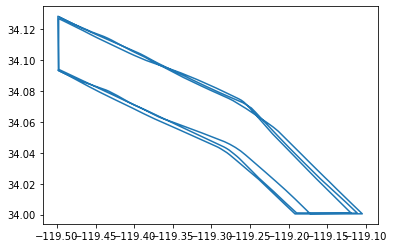

In [19]:
oneVessel = "../Data/M119_50_M119_00_34_00_34_16/MMSI/566952000_Sorted.csv"
# oneVessel = "../Data/M120_00_M190_50_34_12_34_24/MMSI/353544000_Sorted.csv"
# oneVessel = "../Data/M121_00_M119_00_33_50_34_50/MMSI/566952000_Sorted.csv"
oneVesselData,_ = aISDM.load_data_from_csv(oneVessel)
print(oneVesselData.shape)
oneVesselLon = oneVesselData['LON']
oneVesselLat = oneVesselData['LAT']
plt.plot(oneVesselLon,oneVesselLat)

In [20]:
oneVesselTime = oneVesselData['DateTime']
for i in range(oneVesselLon.shape[0]):
    print(oneVesselTime[i])

2017-01-02 04:42:41
2017-01-02 04:43:49
2017-01-02 04:45:01
2017-01-02 04:46:11
2017-01-02 04:47:20
2017-01-02 04:48:31
2017-01-02 04:49:41
2017-01-02 04:50:50
2017-01-02 04:51:51
2017-01-02 04:53:01
2017-01-02 04:54:09
2017-01-02 04:55:10
2017-01-02 04:56:20
2017-01-02 04:57:30
2017-01-02 04:58:41
2017-01-02 04:59:51
2017-01-02 05:01:00
2017-01-02 05:02:10
2017-01-02 05:03:20
2017-01-02 05:04:40
2017-01-02 05:05:51
2017-01-02 05:07:00
2017-01-02 05:08:10
2017-01-02 05:09:21
2017-01-02 05:10:31
2017-01-02 05:11:40
2017-01-02 05:12:51
2017-01-02 05:14:00
2017-01-02 05:15:11
2017-01-02 05:16:21
2017-01-02 05:17:31
2017-01-02 05:18:40
2017-01-02 05:19:51
2017-01-02 05:21:00
2017-01-02 05:22:11
2017-01-02 05:23:21
2017-01-02 05:24:31
2017-01-02 05:25:40
2017-01-02 05:26:51
2017-01-02 05:28:00
2017-01-02 05:29:10
2017-01-02 05:30:21
2017-01-02 05:31:29
2017-01-02 05:32:30
2017-01-02 05:33:40
2017-01-02 05:34:41
2017-01-02 05:35:50
2017-01-02 05:37:00
2017-01-02 05:38:11
2017-01-02 05:39:20


In [21]:
timeIntervalList = "../Data/M119_50_M119_00_34_00_34_16/TimeInterval/HalfHourIntvl1701To1702.txt"
# timeIntervalList = "../Data/M121_00_M119_00_33_50_34_50/TimeInterval/HalfHourIntvl1701To1702.txt"
timeWindows = [line.rstrip('\n') for line in open(timeIntervalList)]

In [22]:
#get the last instance of the position data 
#for one of the vessel
#and that can be used for the prediction
oneVesselLastData = pd.DataFrame()
#based on time stamps 
for timeSlot in timeWindows:
    temp = timeSlot.split(',')
    startTime = temp[0]
    endTime = temp[1]

    timelyDF = aISDM.filter_based_on_time_stamp(oneVesselData,'DateTime',startTime,endTime)
    oneVesselRows = timelyDF.shape[0]
    
    invertedTimelyDF = aISDM.inver_df(timelyDF)
    invertedTimelyDF = invertedTimelyDF.drop_duplicates(subset="MMSI")
    
    oneVesselLastData = oneVesselLastData.append(invertedTimelyDF, ignore_index = True)

In [23]:
print(oneVesselLastData)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   566952000  2017-01-02T04:59:51  34.07902 -119.44413  9.9  106.9    106.0   
1   566952000  2017-01-02T05:29:10  34.05722 -119.35241  9.2  104.7    105.0   
2   566952000  2017-01-02T05:58:50  34.03144 -119.25900  9.7  116.6    116.0   
3   566952000  2017-01-02T06:22:10  34.00045 -119.19174  9.9  119.7    119.0   
4   566952000  2017-01-05T19:59:40  34.02025 -119.14533  7.4 -109.3    300.0   
5   566952000  2017-01-05T20:29:19  34.05142 -119.20845  7.4 -108.4    300.0   
6   566952000  2017-01-05T20:59:30  34.07506 -119.27747  7.4 -122.8    285.0   
7   566952000  2017-01-05T21:29:10  34.09224 -119.35019  7.7 -121.7    285.0   
8   566952000  2017-01-05T21:59:30  34.11077 -119.42170  6.8 -121.1    283.0   
9   566952000  2017-01-05T22:29:40  34.12434 -119.48306  6.0 -123.2    283.0   
10  566952000  2017-01-05T22:37:50  34.12826 -119.49890  6.0 -123.4    283.0   

      VesselName         IMO CallSign  

In [24]:
#divide the journey into two parts
#part 1 is from 0 to 4 included
#part 2 is from 5 to 13 included
oneVesselLastDataOne = oneVesselLastData.iloc[0:4,:]
oneVesselLastDataTwo = oneVesselLastData.iloc[4:,:]

# oneVesselLastDataOne = oneVesselLastData.iloc[0:4,:]

In [25]:
print(oneVesselLastDataOne)

        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566952000  2017-01-02T04:59:51  34.07902 -119.44413  9.9  106.9    106.0   
1  566952000  2017-01-02T05:29:10  34.05722 -119.35241  9.2  104.7    105.0   
2  566952000  2017-01-02T05:58:50  34.03144 -119.25900  9.7  116.6    116.0   
3  566952000  2017-01-02T06:22:10  34.00045 -119.19174  9.9  119.7    119.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
1  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
2  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
3  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   

   Length  Width  Draft  Cargo            DateTime  
0   328.2   45.2   13.0    NaN 2017-01-02 04:59:51  
1   328.2   45.2   13.0    NaN 2017-01-02 05:29:10  
2   328.2   45.2   13.0    NaN 2017-01-02 05:58:50  
3   328.2  

In [26]:
print(oneVesselLastDataTwo)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
4   566952000  2017-01-05T19:59:40  34.02025 -119.14533  7.4 -109.3    300.0   
5   566952000  2017-01-05T20:29:19  34.05142 -119.20845  7.4 -108.4    300.0   
6   566952000  2017-01-05T20:59:30  34.07506 -119.27747  7.4 -122.8    285.0   
7   566952000  2017-01-05T21:29:10  34.09224 -119.35019  7.7 -121.7    285.0   
8   566952000  2017-01-05T21:59:30  34.11077 -119.42170  6.8 -121.1    283.0   
9   566952000  2017-01-05T22:29:40  34.12434 -119.48306  6.0 -123.2    283.0   
10  566952000  2017-01-05T22:37:50  34.12826 -119.49890  6.0 -123.4    283.0   

      VesselName         IMO CallSign  VesselType                  Status  \
4   APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
5   APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
6   APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
7   APL SAVANNAH  IMO9597513   9V9919      1004.0  

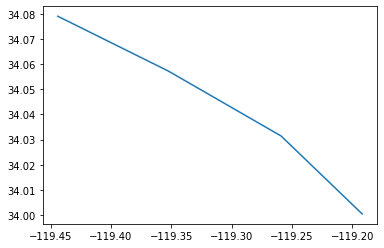

In [27]:
oneVesselLastDataOneLon = oneVesselLastDataOne["LON"]
oneVesselLastDataOneLat = oneVesselLastDataOne["LAT"]
plt.plot(oneVesselLastDataOneLon,oneVesselLastDataOneLat)

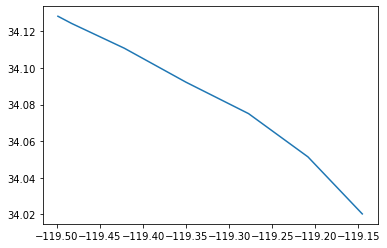

In [28]:
oneVesselLastDataTwoLon = oneVesselLastDataTwo["LON"]
oneVesselLastDataTwoLat = oneVesselLastDataTwo["LAT"]
plt.plot(oneVesselLastDataTwoLon,oneVesselLastDataTwoLat)

In [30]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
onePredict = []
for i in range(2):
    vesselProbState = generate_path(vesselState)
    onePredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

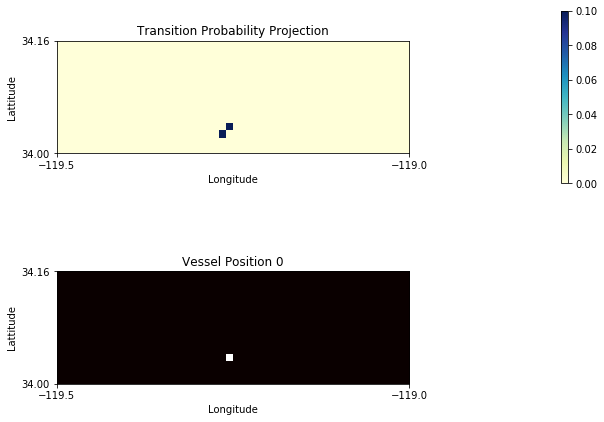

In [31]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataOneLon.iloc[i+2],oneVesselLastDataOneLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
#     vesselProbState = generate_path(vesselState)
#     #copy the file
#     vesselPrevState = vesselCurrState.copy()
#     vesselCurrState = vesselProbState.copy()
#     vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    
    vesselProbState = onePredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=2, interval=1000)

In [32]:
HTML(anim.to_html5_video())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
anim.save('TPSeqOneSecOrder.mp4', writer=writer)

In [33]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
twoPredict = []
for i in range(5):
    vesselProbState = generate_path(vesselState)
    twoPredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

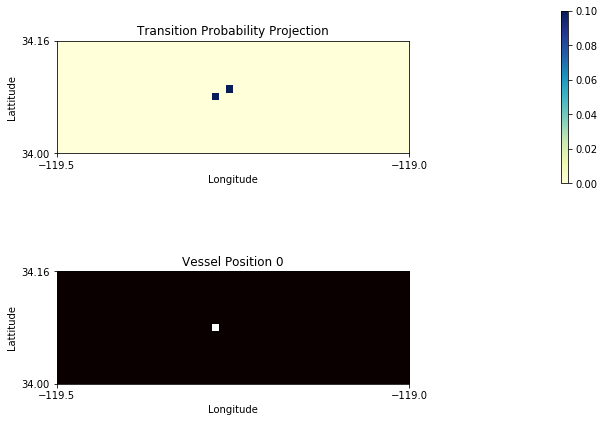

In [34]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[i+2],oneVesselLastDataTwoLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    
    vesselProbState = twoPredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=5, interval=1000)

In [35]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('TPSeqTwoSecOrder.mp4', writer=writer)

In [ ]:
#lets compute the error
predictedLastLoc = np.argmax(twoPredict[-3])
actualLastLoc = get_index_from_lon_lat(oneVesselLastDataTwoLon.iloc[-3],oneVesselLastDataTwoLat.iloc[-3])
print(predictedLastLoc)
print(actualLastLoc)
predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc][0] \
                                                ,boundaryArray[predictedLastLoc][1]\
                                                ,boundaryArray[predictedLastLoc][2]\
                                                ,boundaryArray[predictedLastLoc][3]\
                                                )

actualLastLocCord = hMUtil.compute_mid_point(boundaryArray[actualLastLoc][0] \
                                                ,boundaryArray[actualLastLoc][1]\
                                                ,boundaryArray[actualLastLoc][2]\
                                                ,boundaryArray[actualLastLoc][3]\
                                                )

errorPos = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
print(errorPos)

In [ ]:
oneFirstState = get_index_from_lon_lat(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
print(oneFirstState)
oneFirstStateProb = tpMatrix[oneFirstState,:]
plt.stem(oneFirstStateProb, bottom = -0.01, label = "Transition Probabilities")
plt.legend()
plt.title("Stem Plot For State %d"%(oneFirstState))
plt.savefig("StemPlotOne.png")

In [ ]:
twoFirstState = get_index_from_lon_lat(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
print(twoFirstState)
twoFirstStateProb = tpMatrix[twoFirstState,:]
plt.stem(twoFirstStateProb, bottom = -0.01, label = "Transition Probabilities")
plt.legend()
plt.title("Stem Plot For State %d"%(twoFirstState))
plt.savefig("StemPlotTwo.png")

In [ ]:
vesselState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 4

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])
ax4 = fig.add_axes([0.95, 0.25, 0.01, 0.50])

if useAspect == 1:
    figHeight = figWidth/aspectRatio
    
vesselProbState = vesselState.copy()
for i in range(1,5):
    vesselProbState = vesselProbState + generate_path(vesselState,i)

vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselProbState = np.flip(vesselProbState,axis=0)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
titleStr = 'Vessel Trajectory Density 1'
ax1.set_title(titleStr)
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
    
iMShowHandler = ax1.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
fig.colorbar(iMShowHandler,ax4)
fig.savefig('VesselTrajDen1.png')

In [ ]:
vesselState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 4

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])
ax4 = fig.add_axes([0.95, 0.25, 0.01, 0.50])

if useAspect == 1:
    figHeight = figWidth/aspectRatio
    
vesselProbState = vesselState.copy()
for i in range(1,9):
    vesselProbState = vesselProbState + generate_path(vesselState,i)

vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselProbState = np.flip(vesselProbState,axis=0)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
titleStr = 'Vessel Trajectory Density 2'
ax1.set_title(titleStr)
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
    
iMShowHandler = ax1.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
fig.colorbar(iMShowHandler,ax4)
fig.savefig('VesselTrajDen2.png')

In [ ]:
def compute_heat_map(dF):
#     npHeatMap = np.ones((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    npHeatMap = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for i in range(len(boundaryArray)):
        boundedDF = aISDM.filter_based_on_lon_lat(dF,boundaryArray[i][0]\
            ,boundaryArray[i][1]\
            ,boundaryArray[i][2]\
            ,boundaryArray[i][3]\
            )
        
        if(boundedDF.shape[0] > 0):
#             npHeatMap[i] = 0
            npHeatMap[i] = 1
    
    return npHeatMap

In [ ]:
print(oneVesselData.shape)

In [ ]:
lineCounter = 0
for i in range(oneVesselData.shape[0]):
    print(oneVesselData.iloc[i,16])
    lineCounter = lineCounter + 1
    print(lineCounter)

In [ ]:
oneVesselDataOne = oneVesselData.iloc[0:107,:].copy()
oneVesselDataTwo = oneVesselData.iloc[107:331,:].copy()

In [ ]:
for i in range(oneVesselDataOne.shape[0]):
    print(oneVesselDataOne.iloc[i,16])

In [ ]:
for i in range(oneVesselDataTwo.shape[0]):
    print(oneVesselDataTwo.iloc[i,16])

In [ ]:
vesselState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselActualTrajOne = compute_heat_map(oneVesselDataOne)
vesselActualTrajOne = np.reshape(vesselActualTrajOne,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselActualTrajOne = np.flip(vesselActualTrajOne,axis=0)

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 4

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])
ax4 = fig.add_axes([0.95, 0.25, 0.01, 0.50])

if useAspect == 1:
    figHeight = figWidth/aspectRatio
    
vesselProbState = vesselState.copy()
for i in range(1,5):
    vesselProbState = vesselProbState + generate_path(vesselState,i)

vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselProbState = np.flip(vesselProbState,axis=0)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
titleStr = 'Vessel Trajectory Density 1'
ax1.set_title(titleStr)
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
    
iMShowHandler = ax1.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
ax1.imshow(vesselActualTrajOne,cmap=plt.get_cmap('Reds'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10, alpha = 0.2)
fig.colorbar(iMShowHandler,ax4)
fig.savefig('VesselTrajDen1.png')